In [1]:
#Plot of confirmed Corona cases in selected countries.
#Last update: 2020-03-28, 10:00, JL

import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sta
import scipy.optimize
import statsmodels.stats.api as sms

#https://github.com/CSSEGISandData/COVID-19
url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/'
#fn_confirmed='time_series_19-covid-Confirmed.csv' # deprecated 3/23/2020
fn_confirmed='time_series_covid19_confirmed_global.csv'
#fn_deaths='time_series_19-covid-Deaths.csv'
fn_deaths='time_series_covid19_deaths_global.csv'
#fn_recovered='time_series_19-covid-Recovered.csv'
fn_recovered='time_series_covid19_recovered_global.csv'
fn_population='https://raw.githubusercontent.com/datasets/population/master/data/population.csv'
fn_rkiData='https://opendata.arcgis.com/datasets/dd4580c810204019a7b8eb3e0b329dd6_0.csv'

In [2]:
df_rki=pd.read_csv(fn_rkiData,index_col=None)
df_rki.Meldedatum=pd.to_datetime(df_rki.Meldedatum)

df_rki.head()

,IdBundesland,Bundesland,Landkreis,Altersgruppe,Geschlecht,AnzahlFall,AnzahlTodesfall,ObjectId,Meldedatum,IdLandkreis,Datenstand,NeuerFall,NeuerTodesfall
0,3,Niedersachsen,SK Wolfsburg,A60-A79,M,1,0,465283,2020-03-26 00:00:00+00:00,3103,29.03.2020 00:00,0,-9
1,3,Niedersachsen,SK Wolfsburg,A60-A79,M,4,0,465284,2020-03-27 00:00:00+00:00,3103,29.03.2020 00:00,1,-9
2,3,Niedersachsen,SK Wolfsburg,A60-A79,W,1,1,465285,2020-03-18 00:00:00+00:00,3103,29.03.2020 00:00,0,0
3,3,Niedersachsen,SK Wolfsburg,A60-A79,W,1,0,465286,2020-03-20 00:00:00+00:00,3103,29.03.2020 00:00,0,-9
4,3,Niedersachsen,SK Wolfsburg,A60-A79,W,1,0,465287,2020-03-22 00:00:00+00:00,3103,29.03.2020 00:00,0,-9


In [3]:
# get John's Hopkins data and consolidate for countries.
def getJHUdata(fn,valName='cases'):
    df = pd.read_csv(fn,index_col=None)
    df=df.drop(['Lat','Long'],axis=1)
    df=df.set_index([*df.columns[:2]])
    df=df.stack().reset_index()
    df.columns=['state','country','date',valName]
    df.date=pd.to_datetime(df.date)
    df=df.groupby(['country','date']).sum().reset_index()
    return df

In [4]:
dfc = getJHUdata(url+fn_confirmed)
dfc.tail()

,country,date,cases
11854,Zimbabwe,2020-03-24,3
11855,Zimbabwe,2020-03-25,3
11856,Zimbabwe,2020-03-26,3
11857,Zimbabwe,2020-03-27,5
11858,Zimbabwe,2020-03-28,7


In [5]:
dfd = getJHUdata(url+fn_deaths,'deaths')
dfd.tail()

,country,date,deaths
11854,Zimbabwe,2020-03-24,1
11855,Zimbabwe,2020-03-25,1
11856,Zimbabwe,2020-03-26,1
11857,Zimbabwe,2020-03-27,1
11858,Zimbabwe,2020-03-28,1


In [6]:
dfr = getJHUdata(url+fn_recovered,'recovered')
dfr.tail()

,country,date,recovered
11854,Zimbabwe,2020-03-24,0
11855,Zimbabwe,2020-03-25,0
11856,Zimbabwe,2020-03-26,0
11857,Zimbabwe,2020-03-27,0
11858,Zimbabwe,2020-03-28,0


In [7]:
# get population data.
# Note, many country names don't match between population and case data.
dfp = pd.read_csv(fn_population)
dfp=dfp[dfp.Year==dfp.Year.max()]
dfp.columns=[*dfp.columns[:-1],'population']
dfp.head()

,Country Name,Country Code,Year,population
56,Arab World,ARB,2016,4.064527e+08
113,Caribbean small states,CSS,2016,7.245472e+06
170,Central Europe and the Baltics,CEB,2016,1.029741e+08
227,Early-demographic dividend,EAR,2016,3.170542e+09
284,East Asia & Pacific,EAS,2016,2.296786e+09


In [8]:
df=dfc.merge(dfd,on=[*dfc.columns[:2]])
df=df.merge(dfr,on=[*dfc.columns[:2]])
df=df.merge(dfp[[dfp.columns[0],'population']],how='left',left_on='country',right_on=dfp.columns[0])
df=df.drop('Country Name',axis=1)
df['date'] = pd.to_datetime(df['date']).dt.date
df.head()

,country,date,cases,deaths,recovered,population
0,Afghanistan,2020-01-22,0,0,0,34656032.0
1,Afghanistan,2020-01-23,0,0,0,34656032.0
2,Afghanistan,2020-01-24,0,0,0,34656032.0
3,Afghanistan,2020-01-25,0,0,0,34656032.0
4,Afghanistan,2020-01-26,0,0,0,34656032.0


In [9]:
# Compute ratios
df['cdRatio']=df.deaths/df.cases
df['casePerPop']=df.cases/df.population
df['activeCases']=df.cases-df.deaths-df.recovered
df['crRatio']=df.recovered/df.cases

df['newCases']=df.groupby(['country']).diff().cases

In [10]:
# Show all country names in the case data
allCountries=sorted(df.country.unique())
for a,b,c in zip(allCountries[::3],allCountries[1::3],allCountries[2::3]):
    print('{:<30}{:<30}{:<}'.format(a,b,c))

Afghanistan                   Albania                       Algeria
Andorra                       Angola                        Antigua and Barbuda
Argentina                     Armenia                       Australia
Austria                       Azerbaijan                    Bahamas
Bahrain                       Bangladesh                    Barbados
Belarus                       Belgium                       Belize
Benin                         Bhutan                        Bolivia
Bosnia and Herzegovina        Brazil                        Brunei
Bulgaria                      Burkina Faso                  Burma
Cabo Verde                    Cambodia                      Cameroon
Canada                        Central African Republic      Chad
Chile                         China                         Colombia
Congo (Brazzaville)           Congo (Kinshasa)              Costa Rica
Cote d'Ivoire                 Croatia                       Cuba
Cyprus                        Czechia 

In [11]:
# Select countries for plots.
plotCountries=['Germany','Italy','Spain','France','Portugal', 'Korea, South','US','China']
ix=df.country.isin(plotCountries)
plotStartDate=pd.to_datetime('2020-02-20')

C:\Users\jlarsch\AppData\Local\Continuum\miniconda3\envs\jlsocial\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


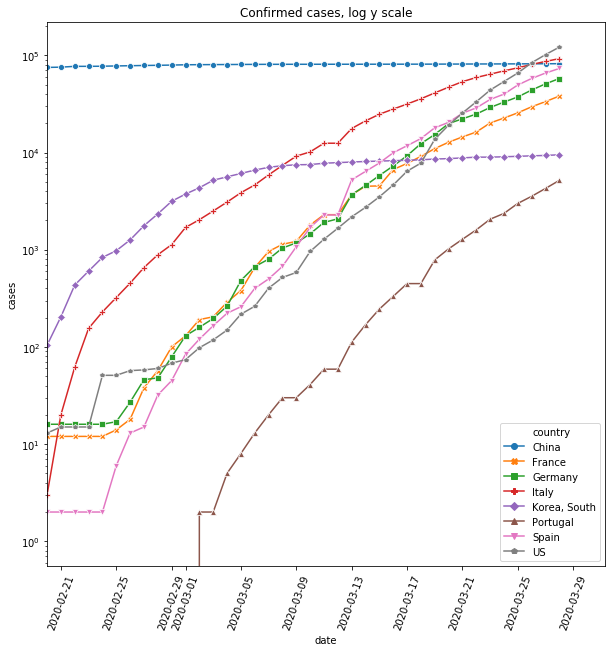

In [12]:
# Plot cases on log y scale
plt.subplots(figsize=(10,10))
ix=df.country.isin(plotCountries)
plotStartDate=pd.to_datetime('2020-02-20')
g=sns.lineplot(data=df[ix],
             x='date',
             y='cases',
            hue='country',
               style='country',
              dashes=False,
              markers=True)
ax = g.axes
ax.set_yscale('log')
plt.title('Confirmed cases, log y scale')
plt.xlim(left=plotStartDate)
plt.xticks(rotation=70);

Note similar slopes of european countries. Italy took of earlier

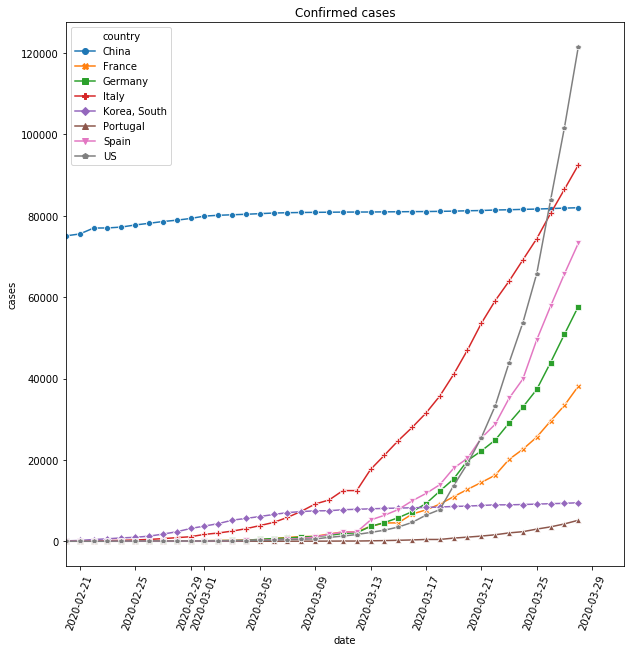

In [13]:
plt.subplots(figsize=(10,10))
ix=df.country.isin(plotCountries)
plotStartDate=pd.to_datetime('2020-02-20')
g=sns.lineplot(data=df[ix],
             x='date',
             y='cases',
            hue='country',
               style='country',
              dashes=False,
              markers=True)

plt.title('Confirmed cases');
plt.xticks(rotation=70);
plt.xlim(left=plotStartDate);

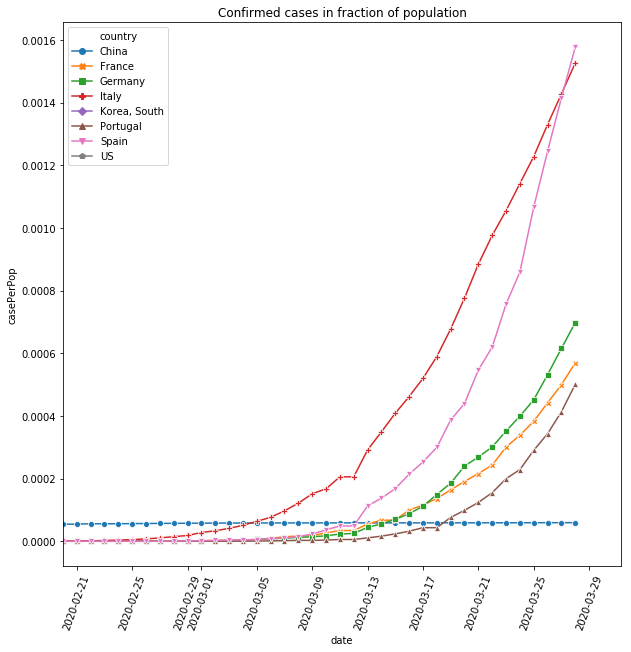

In [14]:
plt.subplots(figsize=(10,10))
ix=df.country.isin(plotCountries)
plotStartDate=pd.to_datetime('2020-02-20')
g=sns.lineplot(data=df[ix],
             x='date',
             y='casePerPop',
            hue='country',
               style='country',
              dashes=False,
              markers=True)

plt.title('Confirmed cases in fraction of population');
plt.xticks(rotation=70);
plt.xlim(left=plotStartDate);

# New cases over time: Have any countries flattened the curve?
inspired by a NYT article -
https://www.nytimes.com/interactive/2020/03/19/world/coronavirus-flatten-the-curve-countries.html

Singapore, Taiwan, Japan, Thailand slowed the onset of exponential growth. South Korea and China managed to reduce new cases greatly.

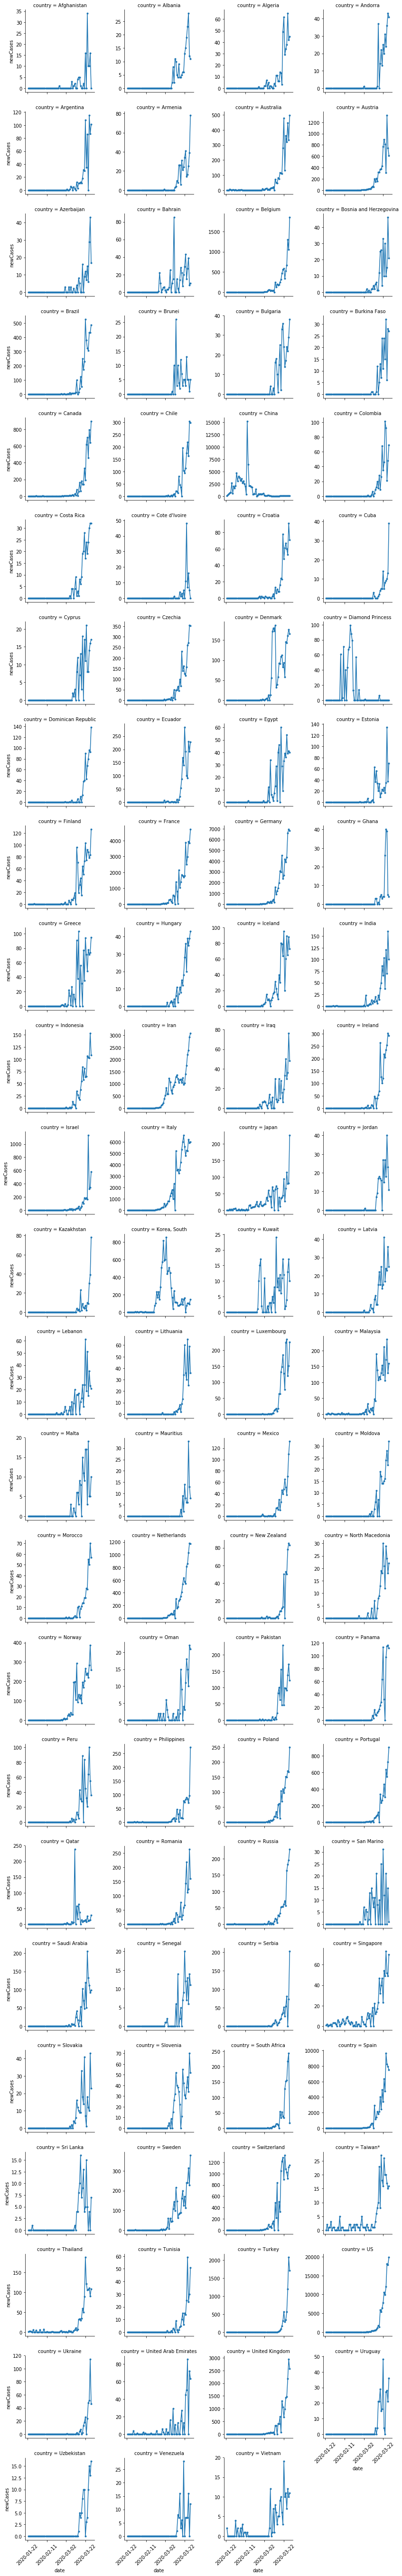

In [15]:
HighCountries=df[df.cases>100].country.unique()
ix=df.country.isin(HighCountries)

g = sns.FacetGrid(df[ix], col="country",  palette="tab20c",
                     col_wrap=4, height=3,sharey=False)

g.map(plt.plot, "date", "newCases",marker='.')

g.set(xticks=df.date.unique()[::20], xticklabels=df.date.unique()[::20])
g.set_xticklabels(rotation=45);



In [16]:
# Show latest data for Germany
ix=df.country.isin(['Germany'])
df.loc[ix][-3:]

,country,date,cases,deaths,recovered,population,cdRatio,casePerPop,activeCases,crRatio,newCases
4285,Germany,2020-03-26,43938,267,5673,82667685.0,0.006077,0.000532,37998,0.129114,6615.0
4286,Germany,2020-03-27,50871,342,6658,82667685.0,0.006723,0.000615,43871,0.130880,6933.0
4287,Germany,2020-03-28,57695,433,8481,82667685.0,0.007505,0.000698,48781,0.146997,6824.0


In [17]:
# Show latest data for US

ix=df.country.isin(['US'])
df.loc[ix][-3:]

,country,date,cases,deaths,recovered,population,cdRatio,casePerPop,activeCases,crRatio,newCases
11119,US,2020-03-26,83836,1209,681,NaN,0.014421,NaN,81946,0.008123,18058.0
11120,US,2020-03-27,101657,1581,869,NaN,0.015552,NaN,99207,0.008548,17821.0
11121,US,2020-03-28,121478,2026,1072,NaN,0.016678,NaN,118380,0.008825,19821.0


# Plot cases aligned to date of crossing 100 cases

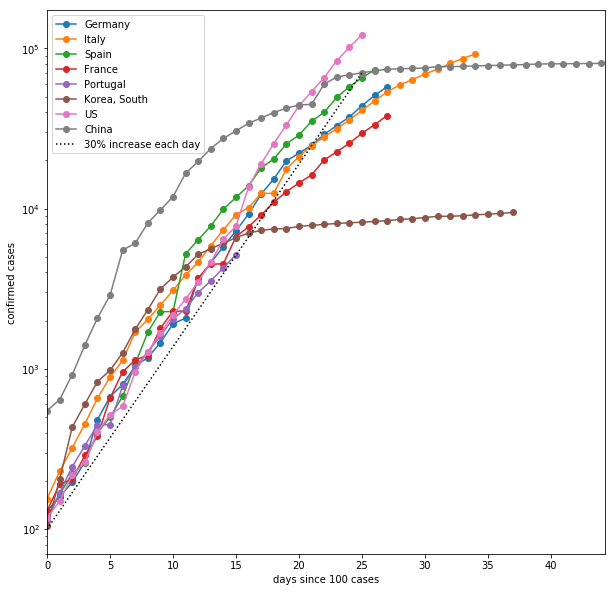

In [18]:
fix,ax=plt.subplots(figsize=(10,10))


for i,c in enumerate(plotCountries):
    ix=df.country==c
    ts=df[ix].cases.values
    if ts[-1]>100:
        inflect=np.argmax(ts>100)
        ax.plot(ts[inflect:],'o-',label=c)
    
t=np.linspace(0,25,100)
e=100*(1+0.3)**t
ax.plot(t,e,':k',label='30% increase each day')
ax.set_yscale('log')
ul=ax.get_xlim()[1]
ax.set_xlim([0,ul-25])
plt.legend()
plt.xlabel('days since 100 cases')
plt.ylabel('confirmed cases');

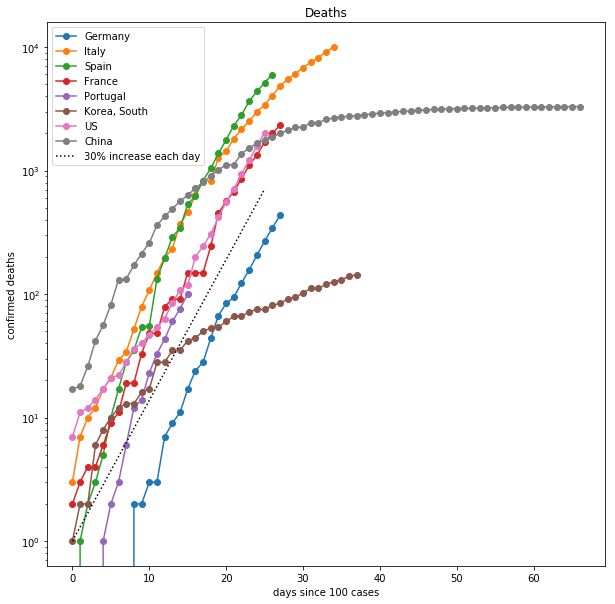

In [19]:
fix,ax=plt.subplots(figsize=(10,10))


for i,c in enumerate(plotCountries):
    ix=df.country==c
    ts=df[ix].cases.values
    if ts[-1]>100:
        inflect=np.argmax(ts>100)
        tsDeaths=df[ix].deaths.values
        ax.plot(tsDeaths[inflect:],'o-',label=c)
    
t=np.linspace(0,25,100)
e=1*(1+0.3)**t
ax.plot(t,e,':k',label='30% increase each day')
ax.set_yscale('log')
plt.legend()
plt.xlabel('days since 100 cases')
plt.ylabel('confirmed deaths')
plt.title('Deaths');

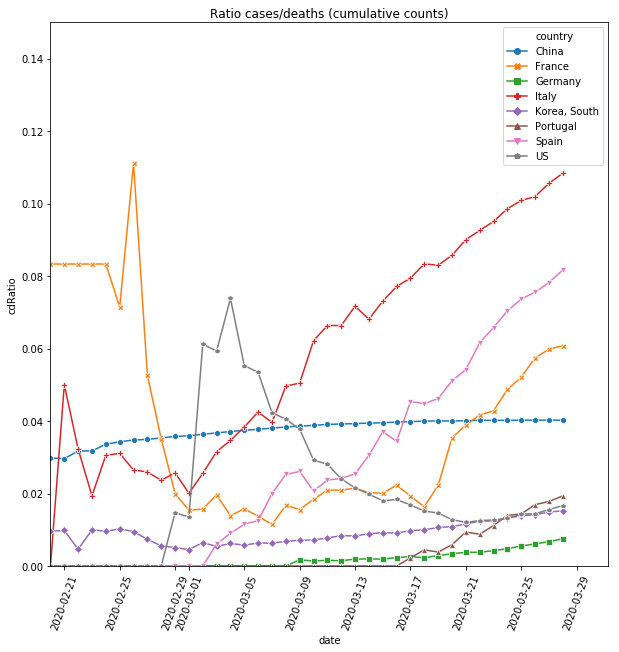

In [20]:
plt.subplots(figsize=(10,10))
ix=df.country.isin(plotCountries)
plotStartDate=pd.to_datetime('2020-02-20')
g=sns.lineplot(data=df[ix],
             x='date',
             y='cdRatio',
            hue='country',
               style='country',
              dashes=False,
              markers=True)

plt.xticks(rotation=70);
plt.ylim([0,.15])
plt.title('Ratio cases/deaths (cumulative counts)')
plt.xlim(left=plotStartDate);

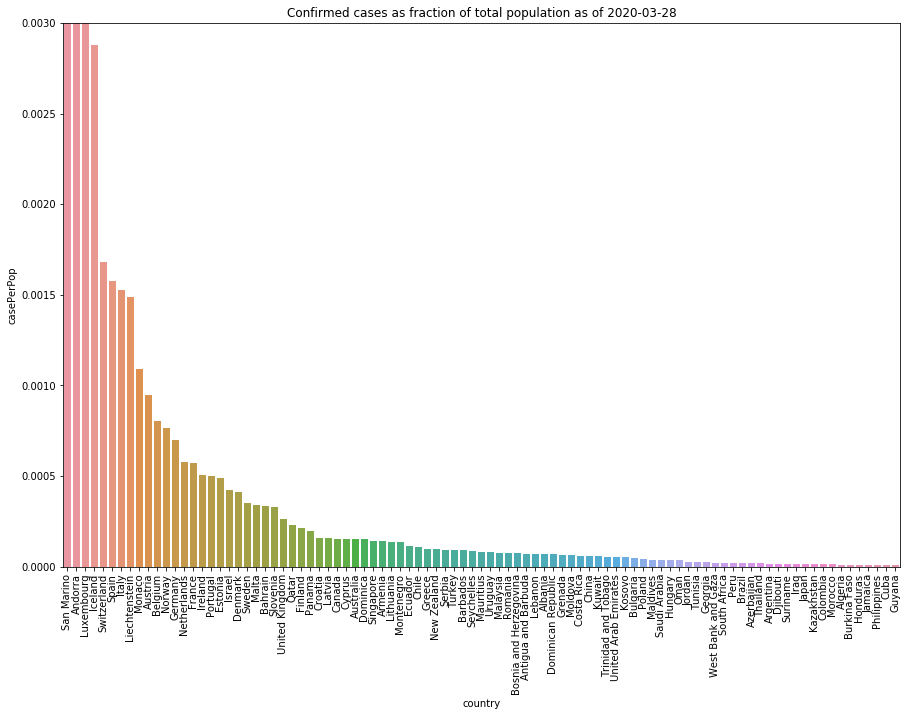

In [21]:
plt.subplots(figsize=(15,10))
ix=(df.date==df.date.max())&(df.casePerPop>0.00001)
sns.barplot(data=df[ix].sort_values(by=['casePerPop'],ascending=False),
            x='country',y='casePerPop')
plt.ylim([0,.003])
plt.title('Confirmed cases as fraction of total population as of '+str(df.date.max()))
plt.xticks(rotation=90);

#  % daily increase in reported cases per country for recent history
## testing only countries with > 250 cases

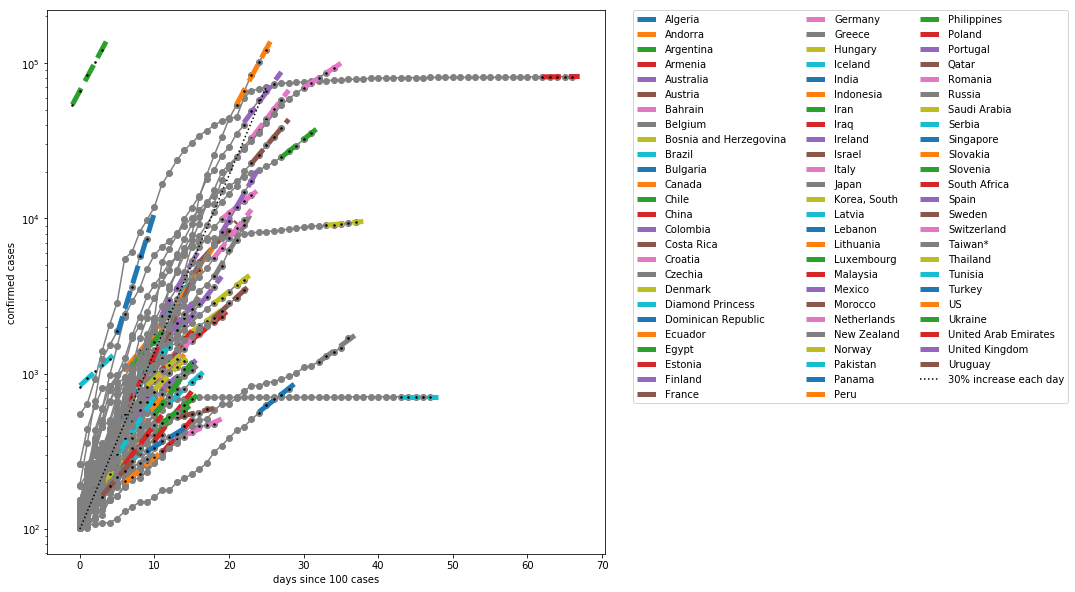

In [22]:
fitHistory=5 #days used for fit

fix,ax=plt.subplots(figsize=(10,10))

HighCountries=df[df.cases>250].country.unique()

allSlopes=np.zeros((len(HighCountries),100))*np.nan
allIntercept=np.zeros((len(HighCountries),100))*np.nan

for i,c in enumerate(HighCountries):
    ix=df.country==c
    ts=df[ix].cases.values
    if ts[-1]>100:
        caseLen=ts.shape[0]
        inflect=np.argmax(ts>100)
        
        for j in range(ts.shape[0]-fitHistory-inflect):
            x=np.arange(fitHistory)
            y=np.log10(ts[j+inflect+1:j+fitHistory+inflect+1])

            s,itc,r,p,std=scipy.stats.linregress(x,y)
            allSlopes[i,j+inflect+1]=s
            allIntercept[i,j+inflect+1]=itc
        
        ax.plot(ts[inflect:],'o-',color='gray')
        t=np.linspace(caseLen-fitHistory-inflect,caseLen-inflect,100)
        tx=np.linspace(0,fitHistory,100)
        l=(10**itc)*(10**(s*tx))
        ax.plot(t,l,'--',label=c,lw=5)
        ax.plot(x+caseLen-fitHistory-inflect,10**y,'k.',markersize=3)
    
t=np.linspace(0,25,100)
e=100*(1+0.3)**t
ax.plot(t,e,':k',label='30% increase each day')
ax.set_yscale('log')
plt.legend(ncol=3,bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel('days since 100 cases')
plt.ylabel('confirmed cases');

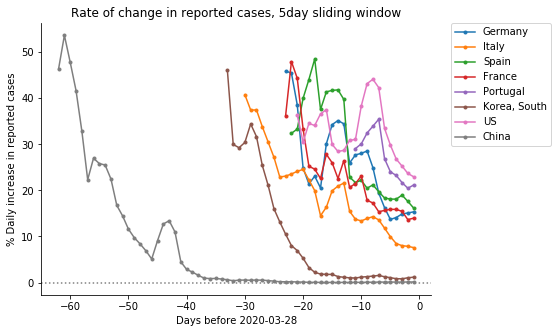

In [23]:
fix,ax=plt.subplots(figsize=(7,5))

today=np.where(np.nansum(allSlopes,axis=0)==0)[0][1]
xt=np.arange(allSlopes.shape[1])-today
for i,c in enumerate(plotCountries):
    ic=np.where(HighCountries==c)[0][0]
    ax.plot(xt,100*(10**allSlopes[ic,:]-1),'.-',label=c);
    #ax.set_xlim([40,70]);
    
plt.legend()
plt.axhline(0,ls=':',color='gray')
plt.ylabel('% Daily increase in reported cases')
plt.xlabel('Days before '+ str(df.date.max()));
plt.title('Rate of change in reported cases, 5day sliding window')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

sns.despine()

#  % daily increase in active cases per country for recent history
## testing only countries with > 250 cases

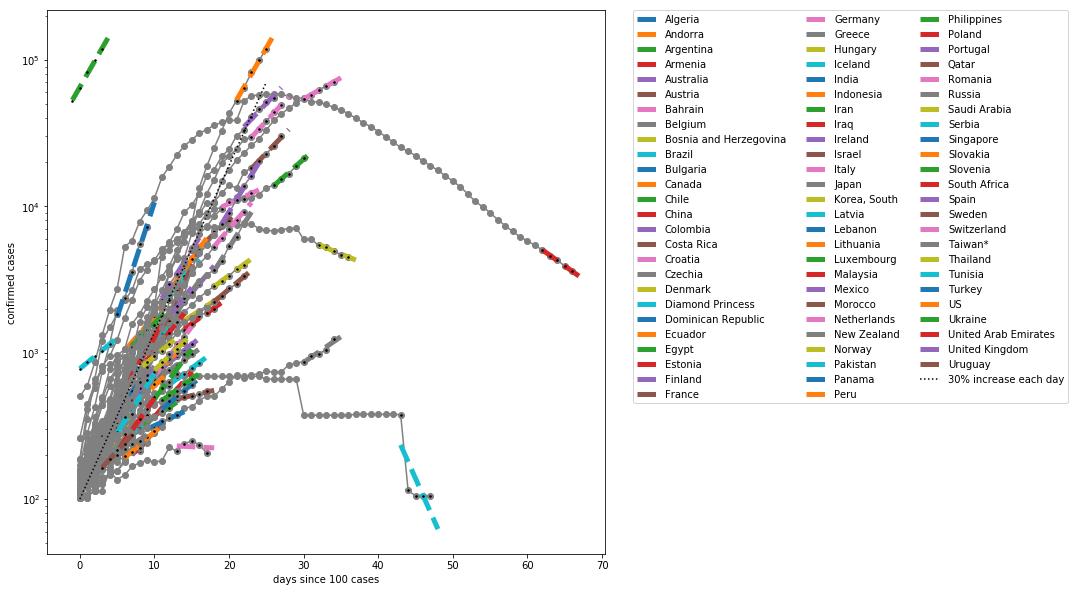

In [24]:
fix,ax=plt.subplots(figsize=(10,10))

allSlopesActive=np.zeros((len(HighCountries),100))*np.nan
allInterceptActive=np.zeros((len(HighCountries),100))*np.nan

for i,c in enumerate(HighCountries):
    ix=df.country==c
    ts=df[ix].activeCases.values
    if ts[-1]>100:
        caseLen=ts.shape[0]
        inflect=np.argmax(ts>100)
        
        for j in range(ts.shape[0]-fitHistory-inflect):
            x=np.arange(fitHistory)
            y=np.log10(ts[j+inflect+1:j+fitHistory+inflect+1])

            s,itc,r,p,std=scipy.stats.linregress(x,y)
            allSlopesActive[i,j+inflect+1]=s
            allInterceptActive[i,j+inflect+1]=itc
        
        ax.plot(ts[inflect:],'o-',color='gray')
        t=np.linspace(caseLen-fitHistory-inflect,caseLen-inflect,100)
        tx=np.linspace(0,fitHistory,100)
        l=(10**itc)*(10**(s*tx))
        ax.plot(t,l,'--',label=c,lw=5)
        ax.plot(x+caseLen-fitHistory-inflect,10**y,'k.',markersize=3)
    
t=np.linspace(0,25,100)
e=100*(1+0.3)**t
ax.plot(t,e,':k',label='30% increase each day')
ax.set_yscale('log')
plt.legend(ncol=3,bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel('days since 100 cases')
plt.ylabel('confirmed cases');

# Summary plot for rates of change

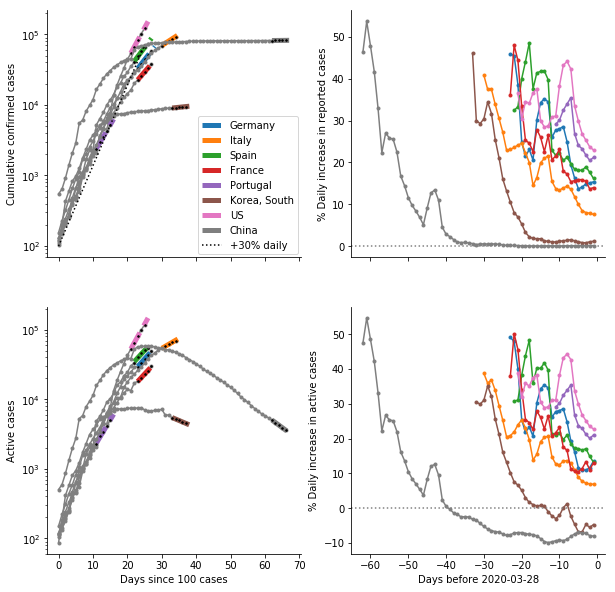

In [25]:
fix,ax=plt.subplots(2,2,figsize=(10,10),sharex='col')
ax=ax.ravel()

for i,c in enumerate(plotCountries):
    ic=np.where(HighCountries==c)[0][0]
    ix=df.country==c
    ts=df[ix].cases.values
    tsA=df[ix].activeCases.values
    
    caseLen=ts.shape[0]
    inflect=np.argmax(ts>100)

    x=np.arange(fitHistory)
    y=np.log10(ts[-fitHistory:])
    yA=np.log10(tsA[-fitHistory:])
    
    t=np.linspace(caseLen-fitHistory-inflect,caseLen-inflect,100)
    tx=np.linspace(0,fitHistory,100)
    j = range(ts.shape[0]-fitHistory-inflect)[-1]
    lastSlope=j+inflect+1
    s=allSlopes[ic,lastSlope]
    itc=allIntercept[ic,lastSlope]
    l=(10**itc)*(10**(s*tx))
    
    sA=allSlopesActive[ic,lastSlope]
    itcA=allInterceptActive[ic,lastSlope]
    lA=(10**itcA)*(10**(sA*tx))
    
    ax[0].plot(ts[inflect:],'.-',color='gray')
    ax[0].plot(t,l,'--',label=c,lw=5)
    ax[0].plot(x+caseLen-fitHistory-inflect,10**y,'k.',markersize=3)
    
    ax[2].plot(tsA[inflect:],'.-',color='gray')
    ax[2].plot(t,lA,'--',label=c,lw=5)
    ax[2].plot(x+caseLen-fitHistory-inflect,10**yA,'k.',markersize=3)


t=np.linspace(0,25,100)
e=100*(1+0.3)**t
ax[0].plot(t,e,':k',label='+30% daily')
ax[0].set_yscale('log')
ax[0].set_ylabel('Cumulative confirmed cases');
ax[2].set_xlabel('Days since 100 cases')
ax[2].set_ylabel('Active cases');
ax[2].set_yscale('log')

today=np.where(np.nansum(allSlopes,axis=0)==0)[0][1]
xt=np.arange(allSlopes.shape[1])-today
for i,c in enumerate(plotCountries):
    ic=np.where(HighCountries==c)[0][0]
    ax[1].plot(xt,100*(10**allSlopes[ic,:]-1),'.-',label=c);
    ax[3].plot(xt,100*(10**allSlopesActive[ic,:]-1),'.-',label=c);
    

ax[1].axhline(0,ls=':',color='gray')
ax[1].set_ylabel('% Daily increase in reported cases')

ax[3].axhline(0,ls=':',color='gray')
ax[3].set_ylabel('% Daily increase in active cases')
ax[3].set_xlabel('Days before '+ str(df.date.max()));


ax[0].legend(loc='lower right', borderaxespad=0.3)

sns.despine()

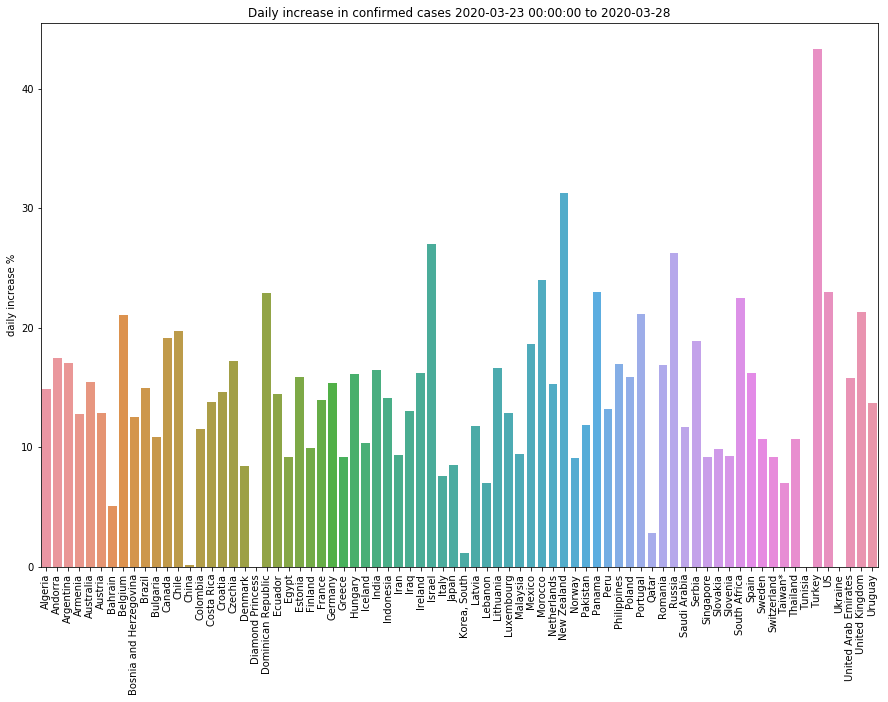

In [26]:
plt.subplots(figsize=(15,10))
sns.barplot(x=HighCountries,y=100*(10**allSlopes[:,today-1]-1))
#plt.ylim([0,.001])
plt.title('Daily increase in confirmed cases '+str(df.date.max()-pd.DateOffset(fitHistory))+' to '+str(df.date.max()))
plt.ylabel('daily increase %')
plt.xticks(rotation=90);

# Recovery

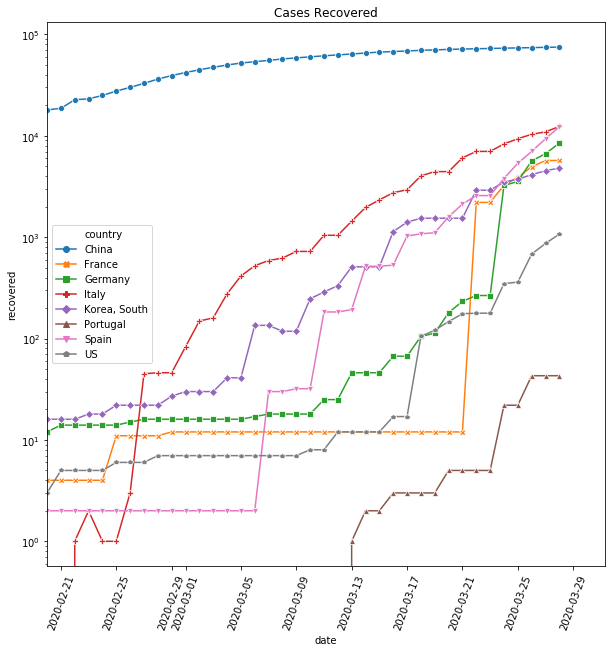

In [27]:
plt.subplots(figsize=(10,10))
ix=df.country.isin(plotCountries)
plotStartDate=pd.to_datetime('2020-02-20')
g=sns.lineplot(data=df[ix],
             x='date',
             y='recovered',
            hue='country',
               style='country',
              dashes=False,
              markers=True)

plt.xticks(rotation=70);
#plt.ylim([0,.1])
plt.title('Cases Recovered')
plt.xlim(left=plotStartDate);
plt.yscale('log')


# Ratio of recovered / total cases

### This ratio will eventually approach mortality, but note ~2-3 week delay from case report to recovery.

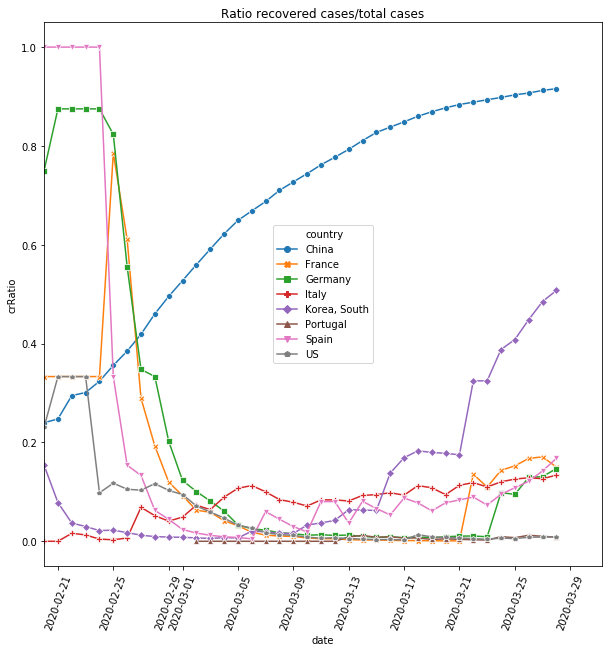

In [28]:
plt.subplots(figsize=(10,10))
ix=df.country.isin(plotCountries)
plotStartDate=pd.to_datetime('2020-02-20')
g=sns.lineplot(data=df[ix],
             x='date',
             y='crRatio',
            hue='country',
               style='country',
              dashes=False,
              markers=True)

plt.xticks(rotation=70);
#plt.ylim([0,.1])
plt.title('Ratio recovered cases/total cases')
plt.xlim(left=plotStartDate);

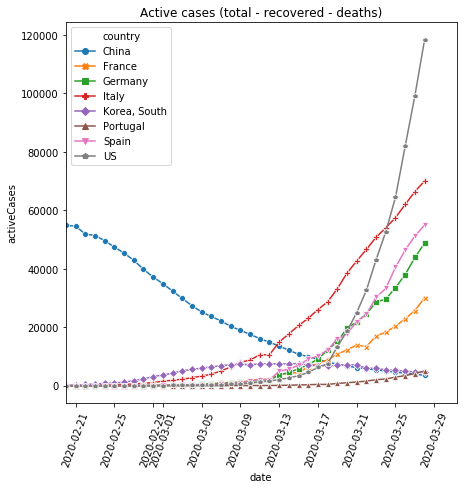

In [29]:
plt.subplots(figsize=(7,7))
ix=df.country.isin(plotCountries)
plotStartDate=pd.to_datetime('2020-02-20')
g=sns.lineplot(data=df[ix],
             x='date',
             y='activeCases',
            hue='country',
               style='country',
              dashes=False,
              markers=True)

plt.xticks(rotation=70);
#plt.ylim([0,.1])
plt.title('Active cases (total - recovered - deaths)')
plt.xlim(left=plotStartDate);

# Compare Robert Koch Institute (RKI) data to John's Hopkins

In [30]:
dfGermany=df[df.country=='Germany']
dfGermany.date=pd.to_datetime(dfGermany.date,utc=True)
tmp=df_rki.groupby('Meldedatum').sum().cumsum().reset_index()
tmp.Meldedatum=pd.to_datetime(tmp.Meldedatum,utc=True)#+pd.DateOffset(2)
dfGermany=dfGermany.merge(tmp[['Meldedatum','AnzahlFall']],how='right',left_on='date',right_on='Meldedatum')
dfGermany.tail()

C:\Users\jlarsch\AppData\Local\Continuum\miniconda3\envs\jlsocial\lib\site-packages\pandas\core\generic.py:5096: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


,country,date,cases,deaths,recovered,population,cdRatio,casePerPop,activeCases,crRatio,newCases,Meldedatum,AnzahlFall
40,Germany,2020-03-24 00:00:00+00:00,32986,157,3243,82667685.0,0.004760,0.000399,29586,0.098314,3930.0,2020-03-24 00:00:00+00:00,36873
41,Germany,2020-03-25 00:00:00+00:00,37323,206,3547,82667685.0,0.005519,0.000451,33570,0.095035,4337.0,2020-03-25 00:00:00+00:00,42229
42,Germany,2020-03-26 00:00:00+00:00,43938,267,5673,82667685.0,0.006077,0.000532,37998,0.129114,6615.0,2020-03-26 00:00:00+00:00,47380
43,Germany,2020-03-27 00:00:00+00:00,50871,342,6658,82667685.0,0.006723,0.000615,43871,0.130880,6933.0,2020-03-27 00:00:00+00:00,51350
44,Germany,2020-03-28 00:00:00+00:00,57695,433,8481,82667685.0,0.007505,0.000698,48781,0.146997,6824.0,2020-03-28 00:00:00+00:00,52534


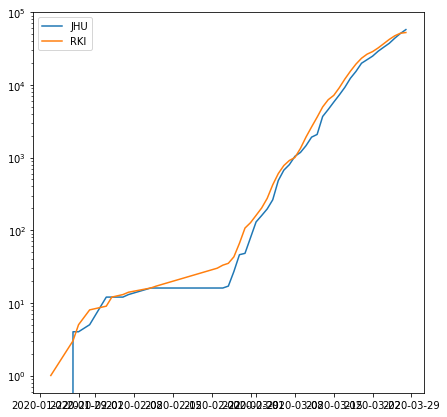

In [31]:
plt.subplots(figsize=(7,7))
plt.plot(dfGermany.date,dfGermany.cases,label='JHU')
plt.plot(dfGermany.date,dfGermany.AnzahlFall,label='RKI')
plt.yscale('log');
plt.legend();

In [32]:
df_rki.head()

,IdBundesland,Bundesland,Landkreis,Altersgruppe,Geschlecht,AnzahlFall,AnzahlTodesfall,ObjectId,Meldedatum,IdLandkreis,Datenstand,NeuerFall,NeuerTodesfall
0,3,Niedersachsen,SK Wolfsburg,A60-A79,M,1,0,465283,2020-03-26 00:00:00+00:00,3103,29.03.2020 00:00,0,-9
1,3,Niedersachsen,SK Wolfsburg,A60-A79,M,4,0,465284,2020-03-27 00:00:00+00:00,3103,29.03.2020 00:00,1,-9
2,3,Niedersachsen,SK Wolfsburg,A60-A79,W,1,1,465285,2020-03-18 00:00:00+00:00,3103,29.03.2020 00:00,0,0
3,3,Niedersachsen,SK Wolfsburg,A60-A79,W,1,0,465286,2020-03-20 00:00:00+00:00,3103,29.03.2020 00:00,0,-9
4,3,Niedersachsen,SK Wolfsburg,A60-A79,W,1,0,465287,2020-03-22 00:00:00+00:00,3103,29.03.2020 00:00,0,-9


# Cases and deaths by age group and gender

Text(0.5, 1.0, 'Faelle in Deutschland')

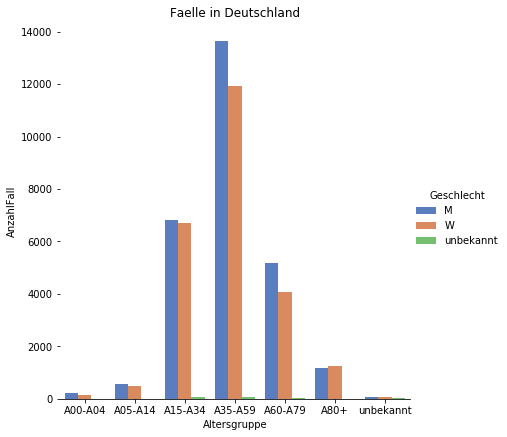

In [33]:
#fix,ax=plt.subplots(figsize=(10,10))

tmp=df_rki.groupby(['Geschlecht','Altersgruppe']).sum().reset_index()
g = sns.catplot(x="Altersgruppe", y="AnzahlFall", hue="Geschlecht", data=tmp,
                height=6, kind="bar", palette="muted")
g.despine(left=True);
plt.title('Faelle in Deutschland')

Text(0.5, 1.0, 'Todesfaelle in Deutschland')

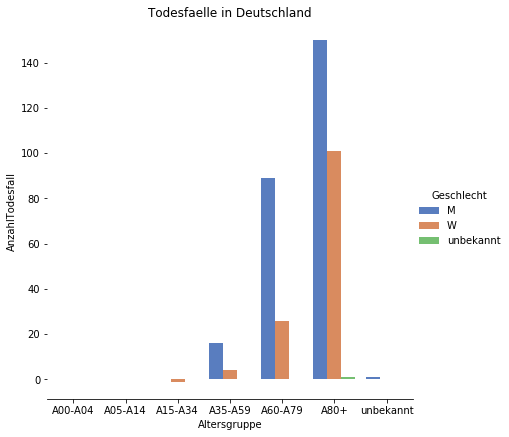

In [34]:
tmp=df_rki.groupby(['Geschlecht','Altersgruppe']).sum().reset_index()
g = sns.catplot(x="Altersgruppe", y="AnzahlTodesfall", hue="Geschlecht", data=tmp,
                height=6, kind="bar", palette="muted")
g.despine(left=True);
plt.title('Todesfaelle in Deutschland')

# Analyze states of Germany

In [35]:
tmp=df_rki.groupby(['Bundesland','Meldedatum']).sum().reset_index()
tmp['cases']=tmp.groupby(['Bundesland']).AnzahlFall.cumsum()
tmp.head()

,Bundesland,Meldedatum,IdBundesland,AnzahlFall,AnzahlTodesfall,ObjectId,IdLandkreis,NeuerFall,NeuerTodesfall,cases
0,Baden-Württemberg,2020-01-24 00:00:00+00:00,8,1,0,475225,8216,0,-9,1
1,Baden-Württemberg,2020-02-23 00:00:00+00:00,72,12,0,4275401,73788,0,-81,13
2,Baden-Württemberg,2020-02-24 00:00:00+00:00,16,2,0,953928,16853,0,-18,15
3,Baden-Württemberg,2020-02-25 00:00:00+00:00,16,2,0,950800,16533,0,-18,17
4,Baden-Württemberg,2020-02-26 00:00:00+00:00,40,5,0,2378733,41483,0,-45,22


C:\Users\jlarsch\AppData\Local\Continuum\miniconda3\envs\jlsocial\lib\site-packages\seaborn\relational.py:792: FutureWarning: Converting timezone-aware DatetimeArray to timezone-naive ndarray with 'datetime64[ns]' dtype. In the future, this will return an ndarray with 'object' dtype where each element is a 'pandas.Timestamp' with the correct 'tz'.
	To accept the future behavior, pass 'dtype=object'.
	To keep the old behavior, pass 'dtype="datetime64[ns]"'.
  x, y = np.asarray(x), np.asarray(y)


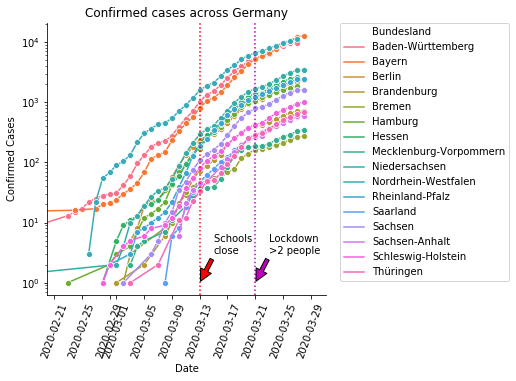

In [36]:
# Plot cases on log y scale
plt.subplots(figsize=(5,5))
plotStartDate=pd.to_datetime('2020-02-20')
g=sns.lineplot(data=tmp,
             x='Meldedatum',
             y='cases',
            hue='Bundesland',
              dashes=False,
              marker='o')
ax = g.axes
ax.set_yscale('log')
plt.title('Confirmed cases across Germany')
plt.xlim(left=plotStartDate)
plt.xticks(rotation=70);
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.axvline(pd.to_datetime('2020-03-13'),ls=':',color='r')
plt.axvline(pd.to_datetime('2020-03-21'),ls=':',color='m')
plt.xlabel('Date')
plt.ylabel('Confirmed Cases')
ax.annotate('Schools \nclose', xy=(pd.to_datetime('2020-03-13'), 1), xytext=(pd.to_datetime('2020-03-15'), 3),
            arrowprops=dict(facecolor='r', shrink=0.05),
            )

ax.annotate('Lockdown \n>2 people', xy=(pd.to_datetime('2020-03-21'), 1), xytext=(pd.to_datetime('2020-03-23'), 3),
            arrowprops=dict(facecolor='m', shrink=0.05),)

sns.despine()

In [37]:
tmp=df_rki.groupby(['Bundesland','Meldedatum']).sum().reset_index()
tmp['cases']=tmp.groupby(['Bundesland']).AnzahlFall.cumsum()
tmp=tmp[['Bundesland','Meldedatum','cases']]
tmp=tmp.pivot_table(columns='Bundesland',index='Meldedatum',values='cases').unstack().reset_index()
tmp.columns=[tmp.columns[0],tmp.columns[1],'cases']
tmp.head()

,Bundesland,Meldedatum,cases
0,Baden-Württemberg,2020-01-24 00:00:00+00:00,1.0
1,Baden-Württemberg,2020-01-28 00:00:00+00:00,NaN
2,Baden-Württemberg,2020-01-29 00:00:00+00:00,NaN
3,Baden-Württemberg,2020-01-31 00:00:00+00:00,NaN
4,Baden-Württemberg,2020-02-03 00:00:00+00:00,NaN


C:\Users\jlarsch\AppData\Local\Continuum\miniconda3\envs\jlsocial\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in greater
  from ipykernel import kernelapp as app


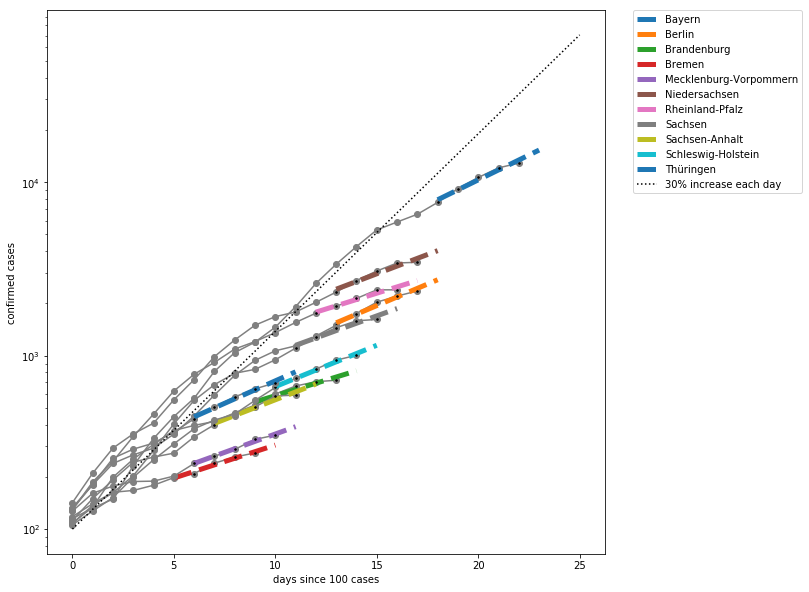

In [62]:
fitHistory=5 #days used for fit

fix,ax=plt.subplots(figsize=(10,10))

numStates=tmp.Bundesland.unique()

allSlopesStates=np.zeros((len(numStates),100))*np.nan

for i,c in enumerate(numStates):
    ix=tmp.Bundesland==c
    ts=tmp[ix].cases.values
    if ts[-1]>100:
        #ts=ts[ts>100]
        caseLen=ts.shape[0]
        inflect=np.argmax(ts>100)
        
        for j in range(ts.shape[0]-fitHistory-inflect):
            x=np.arange(fitHistory)
            y=np.log10(ts[j+inflect+1:j+fitHistory+inflect+1])

            s,itc,r,p,std=scipy.stats.linregress(x,y)
            allSlopesStates[i,j+inflect+1]=s
        
        ax.plot(ts[inflect:],'o-',color='gray')
        t=np.linspace(caseLen-fitHistory-inflect,caseLen-inflect,100)
        tx=np.linspace(0,fitHistory,100)
        l=(10**itc)*(10**(s*tx))
        ax.plot(t,l,'--',label=c,lw=5)
        ax.plot(x+caseLen-fitHistory-inflect,10**y,'k.',markersize=3)
    
t=np.linspace(0,25,100)
e=100*(1+0.3)**t
ax.plot(t,e,':k',label='30% increase each day')
ax.set_yscale('log')
plt.legend(ncol=1,bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel('days since 100 cases')
plt.ylabel('confirmed cases');

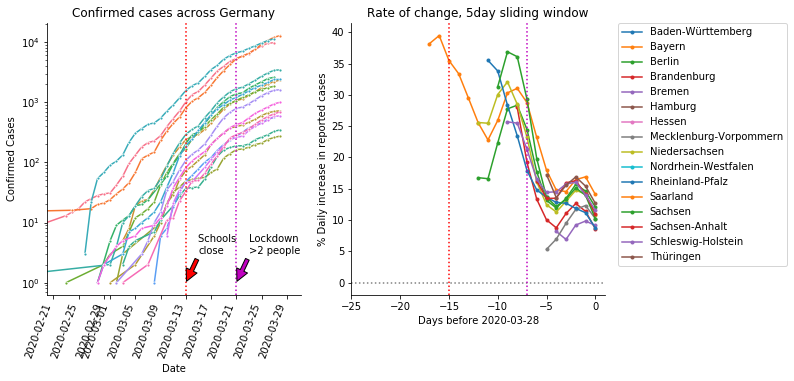

In [63]:
fix,ax=plt.subplots(1,2,figsize=(10,5))
sns.set_palette('tab10',)
# Plot cases on log y scale
plotStartDate=pd.to_datetime('2020-02-20')
g=sns.lineplot(data=tmp,
             x='Meldedatum',
             y='cases',
            hue='Bundesland',
              dashes=False,
              marker='.',ax=ax[0],legend=False)

ax[0].set_yscale('log')
plt.title('Confirmed cases, log y scale')
ax[0].set_xlim(left=plotStartDate)
plt.setp(ax[0].get_xticklabels(), ha="right", rotation=70)
#plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)



today=np.where(np.nansum(allSlopesStates,axis=0)>0)[0][-1]
todayDate=pd.to_datetime(tmp.Meldedatum.max(),utc=True)
xt=np.arange(allSlopesStates.shape[1])-today
for i,c in enumerate(numStates):
    ax[1].plot(xt,100*(10**allSlopesStates[i,:]-1),'.-',label=c);
    #ax.set_xlim([40,70]);
    
plt.axhline(0,ls=':',color='gray')
ax[1].set_ylabel('% Daily increase in reported cases')
ax[1].set_xlabel('Days before '+ str(df.date.max()));
ax[1].title.set_text('Rate of change, 5day sliding window')
ax[0].title.set_text('Confirmed cases across Germany')

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax[1].set_xlim([-25,1])

schoolLD=pd.to_datetime('2020-03-13',utc=True)
publicLD=pd.to_datetime('2020-03-21',utc=True)

ax[0].axvline(schoolLD,ls=':',color='r')
ax[0].axvline(publicLD,ls=':',color='m')
ax[0].set_xlabel('Date')
ax[0].set_ylabel('Confirmed Cases')
ax[0].annotate('Schools \nclose', xy=(schoolLD, 1), xytext=(pd.to_datetime('2020-03-15'), 3),
            arrowprops=dict(facecolor='r', shrink=0.05),
            )

ax[0].annotate('Lockdown \n>2 people', xy=(publicLD, 1), xytext=(pd.to_datetime('2020-03-23'), 3),
            arrowprops=dict(facecolor='m', shrink=0.05),)

df.date.max()

ax[1].axvline((schoolLD-todayDate).days,ls=':',color='r')
ax[1].axvline((publicLD-todayDate).days,ls=':',color='m')

sns.despine()

In [57]:
todayDate

Timestamp('2020-03-28 00:00:00+0000', tz='UTC')

In [54]:
schoolLD

Timestamp('2020-03-13 00:00:00+0000', tz='UTC')

In [55]:
todayDate-schoolLD

Timedelta('15 days 00:00:00')